In [34]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline, splev, splrep
from scipy.optimize import minimize
from scipy.linalg import lstsq
from scipy.sparse import diags

In [35]:
# Parameters (example values; adapt as needed)
class Params:
    collision_weight = 10.0
    time_weight = 1.0
    proximity_weight = 30.0
    velocity_weight = 1.0
    yaw_change_weight = 0.1
    num_samples_collision_likelihood = 10
    num_samples_velocity_score = 10
    obst_scale = 0.6
    cutoff_distance = 4.0


par = Params()

In [47]:
# Helper function for Mahalanobis distance-based collision likelihood
def get_collision_likelihood(agent_trajectory, obstacle_trajectory, current_time, par):
    total_time = agent_trajectory["times"][-1] - current_time
    total_collision_likelihood = 0.0
    for i in range(par.num_samples_collision_likelihood):
        t = current_time + i * total_time / par.num_samples_collision_likelihood
        agent_position = agent_trajectory["position"](t)
        obstacle_position = obstacle_trajectory["position"](t)
        diff = agent_position - obstacle_position
        covariances = ((total_time - t) / total_time) * obstacle_trajectory["ekf_cov"] + (t / total_time) * obstacle_trajectory["poly_cov"]
        mahalanobis_dist = np.sqrt(diff.T @ np.linalg.inv(covariances) @ diff)
        total_collision_likelihood += np.exp(-0.5 * mahalanobis_dist ** 2)
    return total_collision_likelihood / par.num_samples_collision_likelihood

# Helper function to compute velocity score
def get_velocity_score(obstacle_trajectory, current_time, par):
    total_time = obstacle_trajectory["times"][-1] - current_time
    total_velocity_score = 0.0
    for i in range(par.num_samples_velocity_score):
        t = current_time + i * total_time / par.num_samples_velocity_score
        velocity = obstacle_trajectory["velocity"](t)
        total_velocity_score += np.linalg.norm(velocity)
    return total_velocity_score / par.num_samples_velocity_score

# Helper function to compute total collision likelihood
def get_total_collision_likelihood(agent_trajectory, obstacle_trajectories, current_time, par, obstacle_id):
    total_collision_likelihood = 0.0
    for i, obstacle_traj in obstacle_trajectories.items():

        # if it's direction of motion, ignore
        if i == "dom":
            continue
        
        # check if the obstacle is near the agent - if not, ignore
        if np.linalg.norm(agent_trajectory["position"](current_time) - obstacle_traj["position"](current_time)) > par.cutoff_distance:
            continue

        if i == obstacle_id:
            total_collision_likelihood += 0
        else:
            total_collision_likelihood += get_collision_likelihood(agent_trajectory, obstacle_traj, current_time, par)
    return total_collision_likelihood

# Helper function to compute total velocity score
def get_total_velocity_score(agent_trajectory, obstacle_trajectories, current_time, par, obstacle_id):
    total_velocity_score = 0.0
    for i, obstacle_traj in obstacle_trajectories.items():

        # if it's direction of motion, ignore
        if i == "dom":
            continue
            
        # check if the obstacle is near the agent - if not, ignore
        if np.linalg.norm(agent_trajectory["position"](current_time) - obstacle_traj["position"](current_time)) > par.cutoff_distance:
            continue

        if i == obstacle_id:
            total_velocity_score += 0
        else:
            total_velocity_score += get_velocity_score(obstacle_traj, current_time, par)
    return total_velocity_score

# Helper function to compute total time since observed
def get_total_time_since_observed(current_node, obstacle_trajectories, obstacle_id, current_time):
    total_time_since_observed = 0
    for i, obstacle_traj in obstacle_trajectories.items():

        # check if the obstacle is near the agent - if not, ignore
        if i != "dom" and np.linalg.norm(agent_trajectory["position"](current_time) - obstacle_traj["position"](current_time)) > par.cutoff_distance:
            continue

        # TODO: we could penalize for not observing the direction of motion differently

        if i == obstacle_id:
            total_time_since_observed += 0
        else:
            total_time_since_observed += current_node.time_since_observed[i]
    return total_time_since_observed

# Helper function to compute total proximity
def get_total_proximity(agent_trajectory, obstacle_trajectories, current_time, par, obstacle_id):
    total_proximity = 0
    for i, obstacle_traj in obstacle_trajectories.items():
        
        # if it's direction of motion, ignore
        if i == "dom":
            continue
        
        # check if the obstacle is near the agent - if not, ignore
        if np.linalg.norm(agent_trajectory["position"](current_time) - obstacle_traj["position"](current_time)) > par.cutoff_distance:
            continue
    
        if i == obstacle_id:
            total_proximity += 0
        else:
            total_proximity += np.linalg.norm(agent_trajectory["position"](current_time) - obstacle_traj["position"](current_time))


    # Larger proximity is better, so we take the reciprocal
    if total_proximity == 0:
        total_proximity = 0
    else:
        total_proximity = 1 / total_proximity
    return total_proximity

# Calculate utility for each obstacle
def compute_utility(agent_trajectory, obstacle_trajectories, current_time, par, current_node, obstacle_id, yaw_diff, time_since_observed):
    
    # Compute collision likelihood for other obstacles
    total_collision_likelihood = get_total_collision_likelihood(agent_trajectory, obstacle_trajectories, current_time, par, obstacle_id)

    # Compute velocity score
    total_velocity_score = get_total_velocity_score(agent_trajectory, obstacle_trajectories, current_time, par, obstacle_id)

    # Compute time since observed (we need to backtrack AStarNode to get this)
    total_time_since_observed = get_total_time_since_observed(current_node, obstacle_trajectories, obstacle_id, current_time)

    # Compute proximity
    proximity_score = get_total_proximity(agent_trajectory, obstacle_trajectories, current_time, par, obstacle_id)
    
    # Compute utility
    utility = (par.collision_weight * total_collision_likelihood +
                par.velocity_weight * total_velocity_score +
                par.time_weight * total_time_since_observed +
                par.proximity_weight * proximity_score +
                par.yaw_change_weight * yaw_diff)
    
    return utility

# Update the time since observed for each obstacle
def update_time_since_observed(current_node, obstacle_id):
    next_time_since_observed = current_node.time_since_observed.copy()
    for i, _ in next_time_since_observed.items():
        if i == obstacle_id:
            next_time_since_observed[i] = 0
        else:
            next_time_since_observed[i] += 1
    return next_time_since_observed

# Define the A* search for yaw sequence optimization
class AStarNode:
    def __init__(self, time, position, yaw, cost, time_since_observed, parent=None):
        self.time = time
        self.position = position
        self.yaw = yaw
        self.cost = cost
        self.parent = parent
        self.time_since_observed = time_since_observed
        
    def __lt__(self, other):
        return self.cost < other.cost

def find_optimal_yaw(agent_trajectory, obstacle_trajectories, initial_pos, initial_yaw, time_horizon, par):

    # Get extended list of obstacles
    extended_obstacle_trajectories = obstacle_trajectories.copy()
    extended_obstacle_trajectories["dom"] = None

    # Initialize A* search
    open_set = []
    best_path = None

    # Initiallize the first nodes for each obstacle
    time_since_observed = {"obst0": 0, "obst1": 0, "dom": 0}
    heapq.heappush(open_set, AStarNode(0, initial_pos, initial_yaw, 0, time_since_observed, None))
    
    while open_set:

        current_node = heapq.heappop(open_set)
        if current_node.time >= time_horizon:
            best_path = current_node
            break

        next_time = current_node.time + 1
        next_position = agent_trajectory["position"](next_time)

        # Create a new branch for each obstacle
        for obstacle_id, obstacle_trajectory in extended_obstacle_trajectories.items():
            
            # Compute utility
            
            if obstacle_id == "dom":
                next_yaw = np.arctan2(agent_trajectory["position"](next_time)[1] - agent_trajectory["position"](current_node.time)[1],
                                agent_trajectory["position"](next_time)[0] - agent_trajectory["position"](current_node.time)[0])
            else:
                next_yaw = np.arctan2(obstacle_trajectory["position"](next_time)[1] - next_position[1],
                                obstacle_trajectory["position"](next_time)[0] - next_position[0])
            
            yaw_diff = np.abs(next_yaw - current_node.yaw)
            utility = compute_utility(agent_trajectory, extended_obstacle_trajectories, current_node.time, par, current_node, obstacle_id, yaw_diff, current_node.time_since_observed[obstacle_id])
            next_time_since_observed = update_time_since_observed(current_node, obstacle_id)
            heapq.heappush(open_set, AStarNode(next_time, next_position, next_yaw, current_node.cost + utility, next_time_since_observed, current_node))
    
    # Backtrack to retrieve yaw sequence
    yaw_sequence = []
    while best_path:
        yaw_sequence.append(best_path.yaw)
        best_path = best_path.parent
    yaw_sequence.reverse()
    
    return yaw_sequence

In [37]:
# Example data for agent and obstacle trajectories
agent_trajectory = {
    "position": lambda t: np.array([1.5 * (t - 2), 1.5, 0]),  # Dummy agent position
    "times": np.linspace(0, 10, 100)
}

obstacle0_trajectory = {
    "position": lambda t: np.array([par.obst_scale * np.sin((t + 1) / 10) + 2 * par.obst_scale * np.sin(2 * (t + 1) / 10), par.obst_scale * np.cos((t + 1) / 10) - 2 * par.obst_scale * np.cos((t + 1) / 10), - par.obst_scale * np.sin(3 * (t + 1) / 10)]),  # Dummy obstacle position
    "velocity": lambda t: par.obst_scale * np.array([1 / 10 * par.obst_scale * np.cos((t + 1) / 10) + 2 / 10 * par.obst_scale * np.cos(2 * (t + 1) / 10), - 1 / 10 * par.obst_scale * np.sin((t + 1) / 10) + 2 / 10 * par.obst_scale * np.sin(2 * (t + 1) / 10), -3 / 10 * par.obst_scale * np.cos(3 * (t + 1) / 10)]),  # Dummy obstacle velocity
    "time_received": 0,
    "ekf_cov": np.eye(3) * 0.5,
    "poly_cov": np.eye(3) * 2.0,
    "times": np.linspace(0, 10, 100)
}

obstacle1_trajectory = {
    "position": lambda t: np.array([par.obst_scale * np.sin((t + 1) / 10) + 2 * par.obst_scale * np.sin(2 * (t + 1) / 10) + 5, par.obst_scale * np.cos((t + 1) / 10) - 2 * par.obst_scale * np.cos((t + 1) / 10) + 3, - par.obst_scale * np.sin(3 * (t + 1) / 10)]),  # Dummy obstacle position
    "velocity": lambda t: par.obst_scale * np.array([1 / 10 * par.obst_scale * np.cos((t + 1) / 10) + 2 / 10 * par.obst_scale * np.cos(2 * (t + 1) / 10), - 1 / 10 * par.obst_scale * np.sin((t + 1) / 10) + 2 / 10 * par.obst_scale * np.sin(2 * (t + 1) / 10), -3 / 10 * par.obst_scale * np.cos(3 * (t + 1) / 10)]),  # Dummy obstacle velocity
    "time_received": 0,
    "ekf_cov": np.eye(3) * 0.5,
    "poly_cov": np.eye(3) * 2.0,
    "times": np.linspace(0, 10, 100)
}

In [48]:
# Run the algorithm
obstacle_trajectories = {"obst0": obstacle0_trajectory, "obst1": obstacle1_trajectory}
optimal_yaw_sequence = find_optimal_yaw(agent_trajectory, obstacle_trajectories, initial_pos=agent_trajectory["position"](0), initial_yaw=0, time_horizon=10, par=par)
print("Optimal Yaw Sequence:", optimal_yaw_sequence)

Optimal Yaw Sequence: [0, np.float64(-0.7857661886359861), np.float64(-1.1796896468677243), np.float64(-1.7658459483522517), np.float64(-2.2695365410680313), np.float64(0.0), np.float64(1.070561361414384), np.float64(2.2480778170462115), np.float64(2.696288660726336), np.float64(2.849048054249132), np.float64(0.0)]


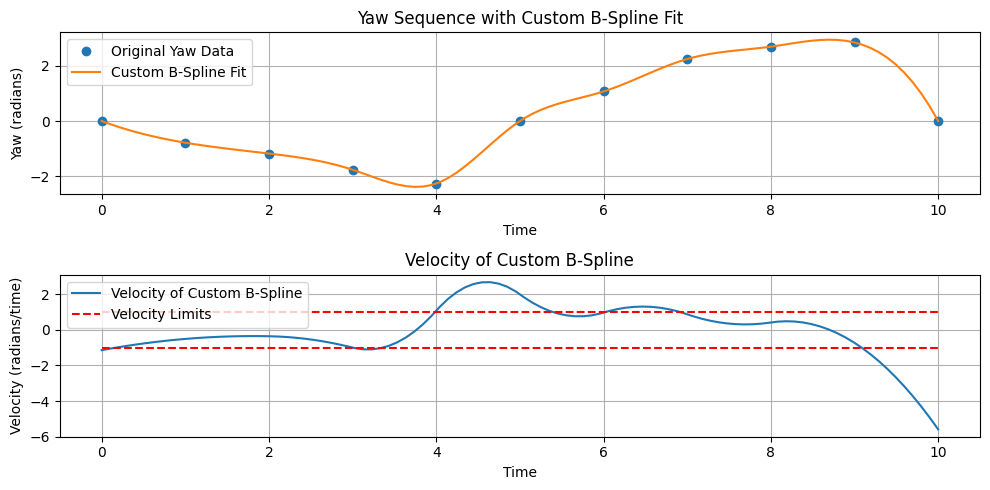

In [49]:
# Test fitting a B-spline to the yaw sequence
time_steps = np.linspace(0, 10, len(optimal_yaw_sequence))

# Define velocity limits
max_velocity = 1.0  # Maximum allowed velocity
min_velocity = -1.0  # Minimum allowed velocity

# Initial B-spline fit
t, c, k = splrep(time_steps, optimal_yaw_sequence, k=3)  # k=3 for cubic B-spline
spline = BSpline(t, c, k, extrapolate=False)
velocity_spline = spline.derivative(nu=1)

# Generate smooth values for plotting
time_smooth = np.linspace(time_steps.min(), time_steps.max(), 100)
yaw_smooth = splev(time_smooth, spline)
velocity_smooth = splev(time_smooth, velocity_spline)

# Plot original data, B-spline fit, and velocity
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(time_steps, optimal_yaw_sequence, 'o', label='Original Yaw Data')
plt.plot(time_smooth, yaw_smooth, '-', label='Custom B-Spline Fit')
plt.xlabel('Time')
plt.ylabel('Yaw (radians)')
plt.legend()
plt.grid()
plt.title('Yaw Sequence with Custom B-Spline Fit')

plt.subplot(2, 1, 2)
plt.plot(time_smooth, velocity_smooth, label='Velocity of Custom B-Spline')
plt.hlines([max_velocity, min_velocity], time_smooth.min(), time_smooth.max(), colors='r', linestyles='dashed', label='Velocity Limits')
plt.xlabel('Time')
plt.ylabel('Velocity (radians/time)')
plt.legend()
plt.grid()
plt.title('Velocity of Custom B-Spline')

plt.tight_layout()
plt.show()

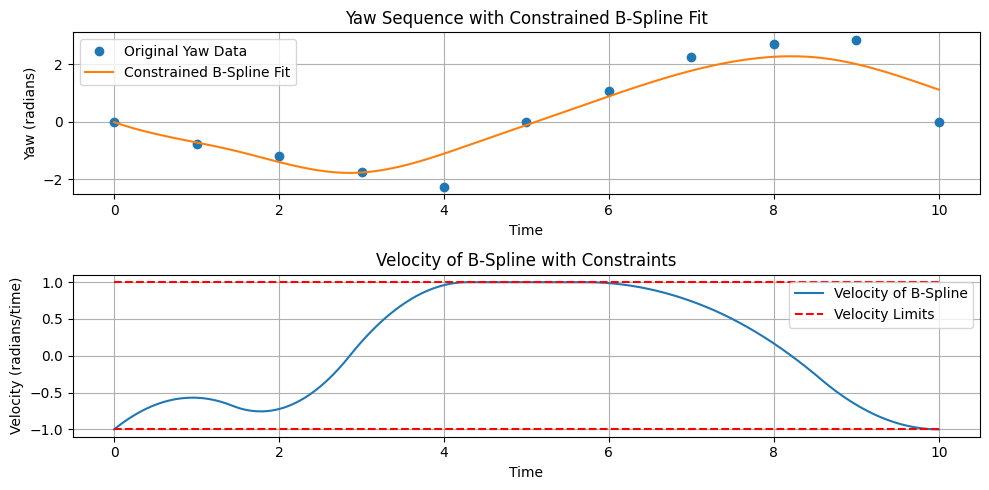

In [46]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import BSpline, splev

# Define B-spline parameters
degree = 3  # Cubic B-spline
num_control_points = 10  # Adjust based on data length

# Define knots (uniform in this example)
knots = np.linspace(time_steps.min(), time_steps.max(), num_control_points - degree + 1)
knots = np.concatenate(([knots[0]] * degree, knots, [knots[-1]] * degree))

# Initialize control points (could be random or based on initial fit)
initial_control_points = np.random.rand(num_control_points)

# Define velocity limits
max_velocity = 1.0  # Max velocity limit
min_velocity = -1.0  # Min velocity limit

# Objective function to fit yaw sequence while adjusting control points within velocity limits
def objective_with_velocity_constraints(control_points):
    # Compute the squared error between the B-spline fit and the optimal yaw sequence
    yaw_fit_error = np.sum((splev(time_steps, BSpline(knots, control_points, degree), der=0) - optimal_yaw_sequence) ** 2)
    return yaw_fit_error

# Define the derivative constraints (velocity limits)
def constraint_velocity(control_points):
    constraints = []
    for i in range(0, len(control_points) - 1):
        # Calculate the velocity between adjacent control points
        velocity_control_points = degree * (control_points[i + 1] - control_points[i]) / (knots[i + degree + 1] - knots[i + 1])
        
        # Apply the max and min velocity constraints
        constraints.append(max_velocity - velocity_control_points)  # max constraint
        constraints.append(velocity_control_points - min_velocity)  # min constraint

    return np.array(constraints)

# Set up the optimization problem
result = minimize(
    objective_with_velocity_constraints,
    initial_control_points,
    constraints={'type': 'ineq', 'fun': constraint_velocity},
    tol=1e-6,
    options={'maxiter': 1000}
)

# Extract optimized control points if successful
optimized_control_points = result.x
spline_with_constraints = BSpline(knots, optimized_control_points, degree)

# Generate smooth time series for plotting
time_smooth = np.linspace(time_steps.min(), time_steps.max(), 200)
constrained_yaw_smooth = splev(time_smooth, spline_with_constraints, der=0)
constrained_velocity_smooth = splev(time_smooth, spline_with_constraints, der=1)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(time_steps, optimal_yaw_sequence, 'o', label='Original Yaw Data')
plt.plot(time_smooth, constrained_yaw_smooth, '-', label='Constrained B-Spline Fit')
plt.xlabel('Time')
plt.ylabel('Yaw (radians)')
plt.legend()
plt.grid()
plt.title('Yaw Sequence with Constrained B-Spline Fit')

plt.subplot(2, 1, 2)
plt.plot(time_smooth, constrained_velocity_smooth, label='Velocity of B-Spline')
plt.hlines([max_velocity, min_velocity], time_smooth.min(), time_smooth.max(), colors='r', linestyles='dashed', label='Velocity Limits')
plt.xlabel('Time')
plt.ylabel('Velocity (radians/time)')
plt.legend()
plt.grid()
plt.title('Velocity of B-Spline with Constraints')

plt.tight_layout()
plt.show()


sample_indices:  [ 0  1  2  3  4  5  6  7  8 10]
constrained_sample_indices:  [  0  22  44  66  88 110 132 154 176 199]


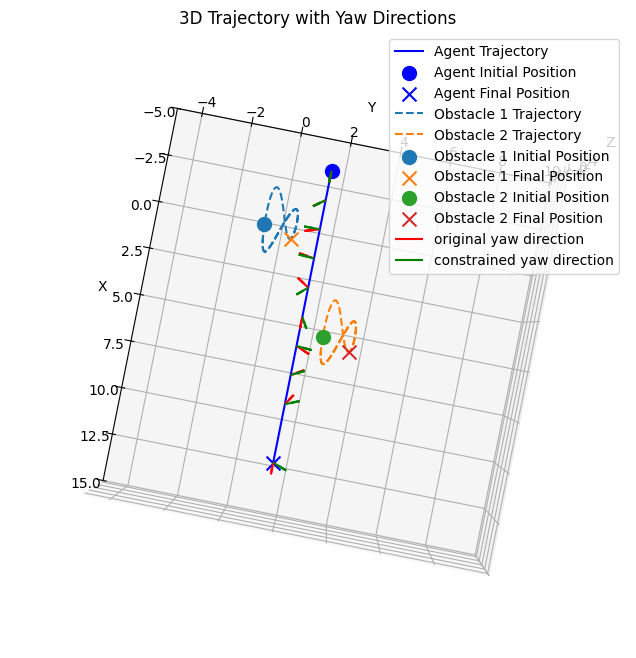

In [43]:
# Plot the trajectory

time_steps_for_agent = np.arange(len(optimal_yaw_sequence))
time_steps_for_obstacle = np.arange(len(obstacle0_trajectory["times"]))
agent_positions = np.array([agent_trajectory["position"](t) for t in time_steps_for_agent])
obstacle_positions = [np.array([traj["position"](t) for t in time_steps_for_obstacle]) for traj in obstacle_trajectories.values()]

# 3D Plot: Agent and Obstacles' Trajectories with Yaw Directions
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot agent trajectory
ax.plot(agent_positions[:, 0], agent_positions[:, 1], agent_positions[:, 2], label='Agent Trajectory', color='blue')

# Plot agent's initial and final positions as points
ax.scatter(agent_positions[0, 0], agent_positions[0, 1], agent_positions[0, 2], label='Agent Initial Position', color='blue', marker='o', s=100)
ax.scatter(agent_positions[-1, 0], agent_positions[-1, 1], agent_positions[-1, 2], label='Agent Final Position', color='blue', marker='x', s=100)

# Plot obstacles' trajectories
for i, obs_pos in enumerate(obstacle_positions):
    ax.plot(obs_pos[:, 0], obs_pos[:, 1], obs_pos[:, 2], label=f'Obstacle {i+1} Trajectory', linestyle='--')

# Plot obstacles' initial and final positions as points
for i, obs_pos in enumerate(obstacle_positions):
    ax.scatter(obs_pos[0, 0], obs_pos[0, 1], obs_pos[0, 2], label=f'Obstacle {i+1} Initial Position', marker='o', s=100)
    ax.scatter(obs_pos[-1, 0], obs_pos[-1, 1], obs_pos[-1, 2], label=f'Obstacle {i+1} Final Position', marker='x', s=100)

# Add yaw direction vectors at sampled time steps
sample_indices = np.linspace(0, len(time_steps_for_agent) - 1, num=10, dtype=int)  # Adjust number of samples as needed
yaw_vectors = np.array([np.array([np.cos(optimal_yaw_sequence[i]), np.sin(optimal_yaw_sequence[i]), 0]) for i in sample_indices])
constrained_sample_indices = np.linspace(0, len(time_smooth) - 1, num=10, dtype=int)  # Adjust number of samples as needed

print("sample_indices: ", sample_indices)
print("constrained_sample_indices: ", constrained_sample_indices)

constrained_yaw_vectors = np.array([np.array([np.cos(constrained_yaw_smooth[i]), np.sin(constrained_yaw_smooth[i]), 0]) for i in constrained_sample_indices])

for idx, sample_idx in enumerate(sample_indices):
    pos = agent_positions[sample_idx]
    yaw_vector = yaw_vectors[idx]
    ax.quiver(pos[0], pos[1], pos[2], yaw_vector[0], yaw_vector[1], yaw_vector[2],
              length=0.6, color='red', arrow_length_ratio=0.6, label="original yaw direction" if idx == 0 else None)
    constrained_yaw_vector = constrained_yaw_vectors[idx]
    ax.quiver(pos[0], pos[1], pos[2], constrained_yaw_vector[0], constrained_yaw_vector[1], constrained_yaw_vector[2],
              length=0.6, color='green', arrow_length_ratio=0.6, label="constrained yaw direction" if idx == 0 else None)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectory with Yaw Directions')
ax.legend()

# Set axis limits
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 10])
ax.set_zlim([-5, 5])

# Angle for rotating the plot
ax.view_init(elev=90, azim=10)

plt.show()
